# Guardians of the Memory - First EDA - Classification - Felix

In this notebook we treat the prediction of HDD breakdown as a classification problem. We think about what data to use and how to preprocess it. Afterwards we have a first look on the features and perform a first EDA.

The notebook is structured as follows:
1. 

## Setup workspace and connect to SQL

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score

RSEED = 42


In [2]:
# Load env file with connection details
load_dotenv("../.env")
DB_STRING = os.getenv('DB_STRING')
# Create engine to use with pandas
db = create_engine(DB_STRING)

## Select data

Since we have a huge imbalanced dataset, we pick specific HDDs at specific dates. We pick the latest 1000 HDDs that failed and focus on one model.

First, we query the failures by model.

In [3]:
query_string = """SELECT model, COUNT(model), failure FROM "2021"
                GROUP BY model, failure
                HAVING failure = '1'
                ORDER BY count DESC"""
#count_failed_by_model = pd.read_sql(query_string, db)
count_failed_by_model = pd.read_csv("../data/interim/count_failed_by_model.csv")
count_failed_by_model.head(5)

,model,count,failure
0,ST4000DM000,475,1
1,ST12000NM0007,390,1
2,ST8000NM0055,301,1
3,ST12000NM0008,289,1
4,TOSHIBA MG07ACA14TA,272,1


As a start, we pick the model `ST4000DM000` (Seagate) and pick the latest 100 drives that failed.

In [49]:
query_string = """SELECT * FROM "2021"
                WHERE model = 'ST4000DM000' AND failure = '1'
                ORDER BY date DESC
                LIMIT 250"""
df_failed = pd.read_sql(query_string, db, parse_dates="date")
df_failed.head(5)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-12-31,Z304GSQ0,ST4000DM000,4000787030016,1,104,12689626,None,None,91,...,None,None,None,None,None,None,None,None,None,None
1,2021-12-30,Z305AQQP,ST4000DM000,4000787030016,1,117,144131312,None,None,91,...,None,None,None,None,None,None,None,None,None,None
2,2021-12-28,Z30149L0,ST4000DM000,4000787030016,1,114,72330272,None,None,92,...,None,None,None,None,None,None,None,None,None,None
3,2021-12-26,Z302SWBN,ST4000DM000,4000787030016,1,108,16925000,None,None,91,...,None,None,None,None,None,None,None,None,None,None
4,2021-12-24,Z305K296,ST4000DM000,4000787030016,1,119,218225696,None,None,93,...,None,None,None,None,None,None,None,None,None,None


We use those HDDs and pick a snapshot of at a random date between 0 and 30 days before they fail. Those observations will obtain the label `fail_30_days` indicating that they will fail in the next 30 days.

In [50]:
df = df_failed.copy() # Copy dataframe
failed_numbers = df.iloc[:,:2]
# Loop over all the HDDs in our dataframe
for num, date, serial_number in tqdm(failed_numbers.itertuples()):
    date = date - pd.Timedelta(np.random.randint(1,30), 'days') # Substract random number of days
    # Generate SQL query
    query_string = f"""SELECT * FROM "2021" WHERE date = '{date.strftime('%Y-%m-%d')}' AND serial_number = '{serial_number}'"""
    snapshot = pd.read_sql(query_string, db, parse_dates="date")
    #snapshot = df.iloc[num,:]
    df = df.append(snapshot, ignore_index=True) # Append the snapshot to the dataframe
df = df.infer_objects() # Fix column types
df.shape

250it [00:30,  8.22it/s]


(485, 179)

In [51]:
df["fail_30_days"] = 1

Additionally, we capture 5 snapshots at random times between 600 and 30 days before they break down.

In [53]:
for k in range(5): # Repeat 5 times
    # Loop over all the HDDs in our dataframe
    for num, date, serial_number in tqdm(failed_numbers.itertuples()):
        date = date - pd.Timedelta(np.random.randint(31,600), 'days') # Substract random number of days
        # Generate SQL query
        query_string = f"""SELECT * FROM "2021" WHERE date = '{date.strftime('%Y-%m-%d')}' AND serial_number = '{serial_number}'"""
        snapshot = pd.read_sql(query_string, db, parse_dates="date")
        #snapshot = df.iloc[num,:]
        df = df.append(snapshot, ignore_index=True) # Append the snapshot to the dataframe
#df = pd.read_csv("../data/interim/felix.csv", parse_dates=["date"])
df = df.infer_objects() # Fix column types
df.shape

250it [00:31,  7.91it/s]
250it [00:31,  7.92it/s]
250it [00:31,  7.89it/s]
250it [00:31,  7.93it/s]
250it [00:31,  7.85it/s]


In [55]:
df["fail_30_days"][486:] = 0

Now we drop the first 250 rows

In [70]:
#df.to_csv("../data/interim/felix.csv", index=False)
df.drop(df.index[:250], axis=0, inplace=True) # Drop first 250 rows
df.drop("failure", axis=1, inplace=True) # Drop the old target
df.reset_index(drop=True, inplace=True) # Reset index

In [7]:
## Random sampling in SQL
# SELECT * FROM myTable
# WHERE attribute = 'myValue'
# ORDER BY random()
# LIMIT 1000;

## Data preprocessing

We backup the dataframe

In [81]:
df_backup = df.copy()
df.to_csv("../data/interim/felix.csv", index=False)
#df = df_backup.copy()

We calculate the capacity (TB) of the HDDs

In [82]:
df["capacity"] = round(df.capacity_bytes / 1.0e12, 2) # Capacity in Terabyte
df.drop("capacity_bytes", axis=1, inplace=True)
df.capacity.unique()

array([4.00078703])

Next we drop the `normalized` S.M.A.R.T. features

In [83]:
cols_to_drop = df.columns[df.columns.str.contains("normalized")] # Column names that contain normalized
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 87
Shape of the dataframe (1254, 92)


Drop columns with more than 20% NaNs

In [84]:
cols_to_drop = df.columns[df.notna().sum() < (0.8 * len(df))] # Columns that contain lot of NaNs
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 63
Shape of the dataframe (1254, 29)


In [85]:
df.columns

Index(['date', 'serial_number', 'model', 'smart_1_raw', 'smart_3_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw',
       'smart_10_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw',
       'smart_191_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw',
       'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw',
       'smart_241_raw', 'smart_242_raw', 'fail_30_days', 'capacity'],
      dtype='object')

**Description of the features**
- **`date`**: datetime
- **`serial_number`**: unique identifier
- **`model`**: model number
- **`failure`**: target
- **`capacity`**: HDD capacity in TB
- `smart1`: read error rate
- `smart3`: spin-up time
- `smart4`: start-stop count
- `smart5`: reallocated sectors count, **CRITICAL**
- `smart7`: seek error rate
- `smart9`: power on hours (expected: 5 years corresponds to 43 800 hours)
- `smart10`: spin retry count, **CRITICAL**
- `smart12`: power cycle count
- `smart183`: Seagate: downshift error count (sign of aging but no direct indicator)
- `smart184`: end-to-end-error, **CRITICAL**
- `smart187`: uncorrectable errors, **CRITICAL**
- `smart188`: command timeout, should be zero, **CRITICAL**
- `smart189`: high fly writes
- `smart190`: temperature difference, 100°C - temp, here: same values as `smart194`
- `smart191`: g-sense error rate (externally induced shock, vibration)
- `smart192`: unsafe shutdown count
- `smart193`: load cycle count (power saving, rated for 300 000 to 600 000)
- `smart194`: temperature
- `smart197`: count of unstable sectors, **CRITICAL**
- `smart198`: count of uncorrectable sectors, **CRITICAL**
- `smart199`: error count for transfer with interface cable, here always 0!
- `smart240`: head flying hours
- `smart241`: total LBA written
- `smart242`: total LBA read

We obtain no information from `smart190` and `smart199`, so we drop them in the following.

In [86]:
df.drop(["smart_190_raw", "smart_199_raw"], axis=1, inplace=True)
print("Shape of the dataframe", df.shape)

Shape of the dataframe (1254, 27)


In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
smart_1_raw,1254.0,1.240863e+08,7.122809e+07,3.758880e+05,6.429975e+07,1.258232e+08,1.869394e+08,2.440375e+08
smart_3_raw,1254.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
smart_4_raw,1254.0,1.361085e+01,8.835650e+00,1.000000e+00,9.000000e+00,1.200000e+01,1.500000e+01,8.200000e+01
smart_5_raw,1254.0,2.744689e+02,3.291029e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.469600e+04
smart_7_raw,1254.0,6.436167e+08,1.757250e+09,5.686000e+03,2.204148e+08,4.714212e+08,7.735713e+08,3.925885e+10
smart_9_raw,1254.0,4.484620e+04,5.471557e+03,2.401200e+04,4.065675e+04,4.556900e+04,4.912200e+04,5.769200e+04
smart_10_raw,1254.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
smart_12_raw,1254.0,1.340670e+01,9.174750e+00,1.000000e+00,9.000000e+00,1.200000e+01,1.500000e+01,8.700000e+01
smart_183_raw,1254.0,6.332536e+00,3.006352e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,5.590000e+02
smart_184_raw,1254.0,1.175439e+00,1.352434e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.330000e+02


A few findings:
- `smart3` spin-up time reported is 0 for all HDDs -> drop it
- `smart10` critical critereon all 0, don't use for now, might be interesting to find HDDs with non 0
- `smart 191` all 0 (no externally induced shocks)
- `capacity` always the same for the same model, makes sense

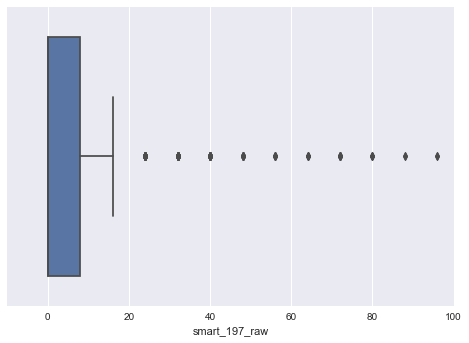

In [90]:
sns.boxplot(df.smart_197_raw)
plt.xlim(-10, 100);

Calculate correlations and mutual information score

In [107]:
df.fail_30_days.fillna(0, inplace=True) # Fill missing target --> check indexing above!!!

In [205]:
scores = mutual_info_classif(df.drop(["fail_30_days", "date", "model", "capacity", "serial_number"], axis=1), df.fail_30_days)
col_names = df.drop(["fail_30_days", "date", "model", "capacity", "serial_number"], axis=1).columns
scores = pd.DataFrame(scores, index=col_names, columns=["MI Score"])
scores["Correlation"] = df.corr().fail_30_days
scores = scores.sort_values("MI Score", ascending=False)
scores.head(10)

,MI Score,Correlation
smart_9_raw,0.167323,0.489537
smart_240_raw,0.154079,0.487189
smart_242_raw,0.118578,0.322942
smart_241_raw,0.062460,0.210865
smart_187_raw,0.049167,0.298454
smart_198_raw,0.036523,0.029188
smart_192_raw,0.035757,0.169440
smart_184_raw,0.034552,0.106533
smart_5_raw,0.028123,0.093682
smart_197_raw,0.024795,0.029188


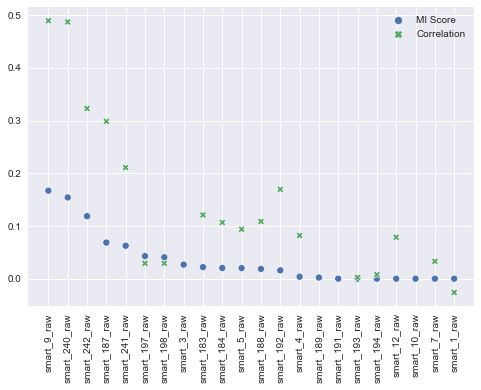

In [110]:
sns.scatterplot(data=scores.sort_values("MI Score", ascending=False))
plt.xticks(rotation=90);

## Details of the most important features

In [206]:
feats = scores.head(5).index
feats

Index(['smart_9_raw', 'smart_240_raw', 'smart_242_raw', 'smart_241_raw',
       'smart_187_raw'],
      dtype='object')

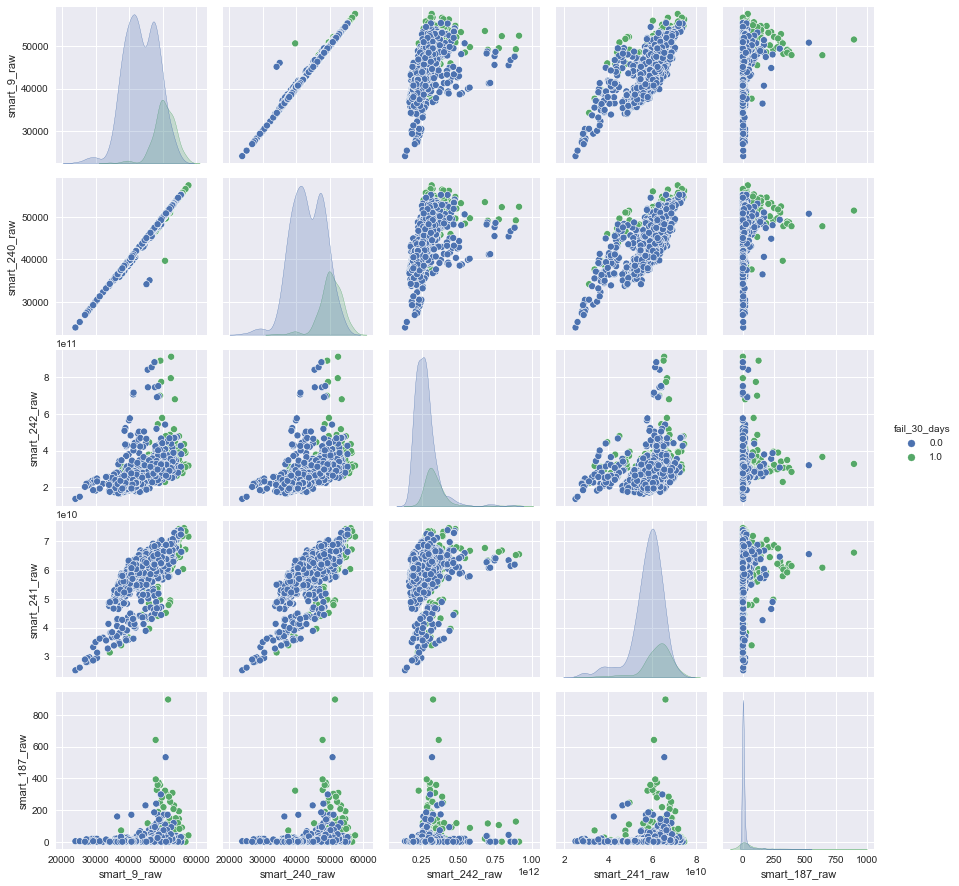

In [207]:
feats = ['smart_9_raw', 'smart_240_raw', 'smart_242_raw', 'smart_241_raw', 'smart_187_raw', 'fail_30_days']
sns.pairplot(data=df[feats], hue="fail_30_days");

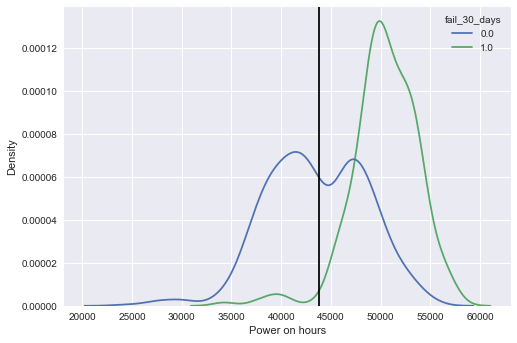

In [214]:
sns.kdeplot(data=df, x="smart_9_raw", hue="fail_30_days", common_norm=False)
plt.axvline(x=43800, color='k')
plt.xlabel("Power on hours");

(0.0, 100.0)

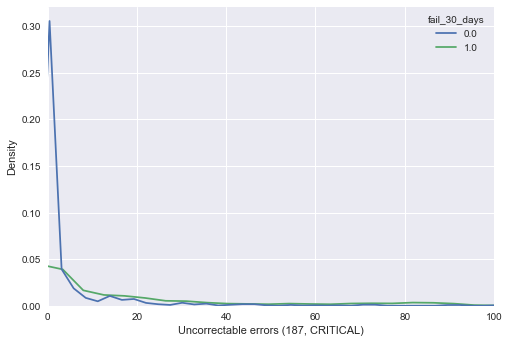

In [225]:
sns.kdeplot(data=df, x="smart_187_raw", hue="fail_30_days", common_norm=False, bw_adjust=0.1)
plt.xlabel("Uncorrectable errors (187, CRITICAL)")
plt.xlim(0,100)
#plt.ylim(0, 100);

Text(0.5, 0, 'Temperature °C')

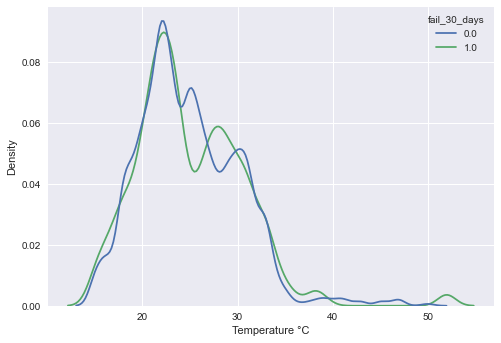

In [242]:
sns.kdeplot(data=df, x="smart_194_raw", hue="fail_30_days", common_norm=False, bw_adjust=0.5)
plt.xlabel('Temperature °C')


Dimensionality Reduction

In [160]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA()
tsne = TSNE(n_components=2, init='random', random_state=RSEED)

(1254, 10)


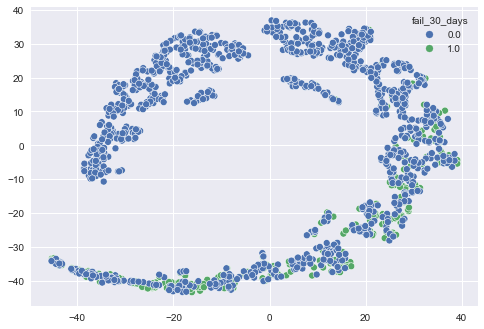

In [245]:
feats = scores.head(10).index
X = df[feats]
y = df.fail_30_days

X_tsne = tsne.fit_transform(X)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y);

## Quick modeling - XGBoost

In [209]:
X = df.copy()
X.drop(["model", "serial_number"], axis=1, inplace=True)
y = X.pop("fail_30_days")

X = pd.DataFrame(X_pca)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)
print("Shape of test data:", X_test.shape)

Shape of test data: (251, 10)


In [210]:
# Preprocessor pipelines
cat_cols = X_train.columns[X_train.dtypes == 'float'].to_numpy()
num_cols = X_train.columns[X_train.dtypes == 'object'].to_numpy()
# Preprocessor for numerical features
num_pipeline = Pipeline([
    ('num_scaler', StandardScaler()),
    #('num_scaler', MinMaxScaler())
])
# Preprocessor for categorical features 
cat_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Put together preprocessor pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
])
# Modeling pipeline
pipe_xgb = Pipeline([
    # ('attr_addr', features_pipeline),
    #('preprocessor', preprocessor),
    ('xgb', XGBClassifier(eval_metric="auc", scale_pos_weight=4))
])

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 2/4] END xgb__learning_rate=0.20765656565656565, xgb__max_depth=38, xgb__n_estimators=450;, score=0.892 total time=   1.0s
[CV 2/4] END xgb__learning_rate=0.46975757575757576, xgb__max_depth=39, xgb__n_estimators=450;, score=0.891 total time=   0.6s
[CV 1/4] END xgb__learning_rate=0.46975757575757576, xgb__max_depth=39, xgb__n_estimators=450;, score=0.912 total time=   0.8s
[CV 4/4] END xgb__learning_rate=0.20765656565656565, xgb__max_depth=38, xgb__n_estimators=450;, score=0.928 total time=   1.1s
[CV 4/4] END xgb__learning_rate=0.46975757575757576, xgb__max_depth=39, xgb__n_estimators=450;, score=0.927 total time=   0.8s
[CV 3/4] END xgb__learning_rate=0.46975757575757576, xgb__max_depth=39, xgb__n_estimators=450;, score=0.918 total time=   0.9s
[CV 1/4] END xgb__learning_rate=0.20765656565656565, xgb__max_depth=38, xgb__n_estimators=450;, score=0.907 total time=   1.2s
[CV 3/4] END xgb__learning_rate=0.2076565656565656

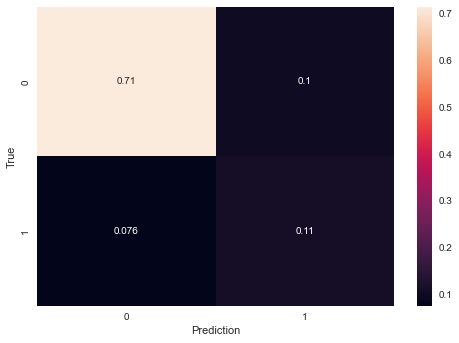

In [211]:
# Defining parameter grid (as dictionary)
param_grid = {'xgb__n_estimators': list(range(100,1000,50)),
              'xgb__learning_rate': list(np.linspace(0.001, 0.5, 100)),
              'xgb__max_depth': list(range(1, 50))
    }
# Instantiate gridsearch and define the metric to optimize 
gs = RandomizedSearchCV(pipe_xgb,  param_grid, scoring='roc_auc',
                  cv=4, verbose=3, n_jobs=-1, n_iter=20)

# Fit gridsearch object to data.
gs.fit(X_train, y_train)

y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred)/len(y_pred), annot=True)
plt.ylabel("True")
plt.xlabel("Prediction")

print("Area under ROC curve:",roc_auc_score(y_test, y_pred))